In [1]:
%pip install plotly pandas numpy nbformat matplotlib
# imports
import pandas as pd
# import matplotlib.pyplot as plt
import plotly.graph_objs as go
import numpy as np


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Charger le dataset
df = pd.read_csv("data/dpt2020.csv", sep=";")

# Supprimer les prénoms "_PRENOMS_RARES"
df = df[df["preusuel"] != "_PRENOMS_RARES"]

# Ajouter une colonne de longueur de prénom
df["longueur"] = df["preusuel"].str.len()

# Supprimer les prénoms de longueur 1
df = df[df["longueur"] > 1]

moyennes = df.groupby(["annais", "sexe"])["longueur"].mean().unstack()

/var/folders/95/gv_9n07j7510pvhlzz5_mld80000gn/T/ipykernel_67051/2982299850.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["longueur"] * g["nombre"]).sum() / g["nombre"].sum())


<Axes: >

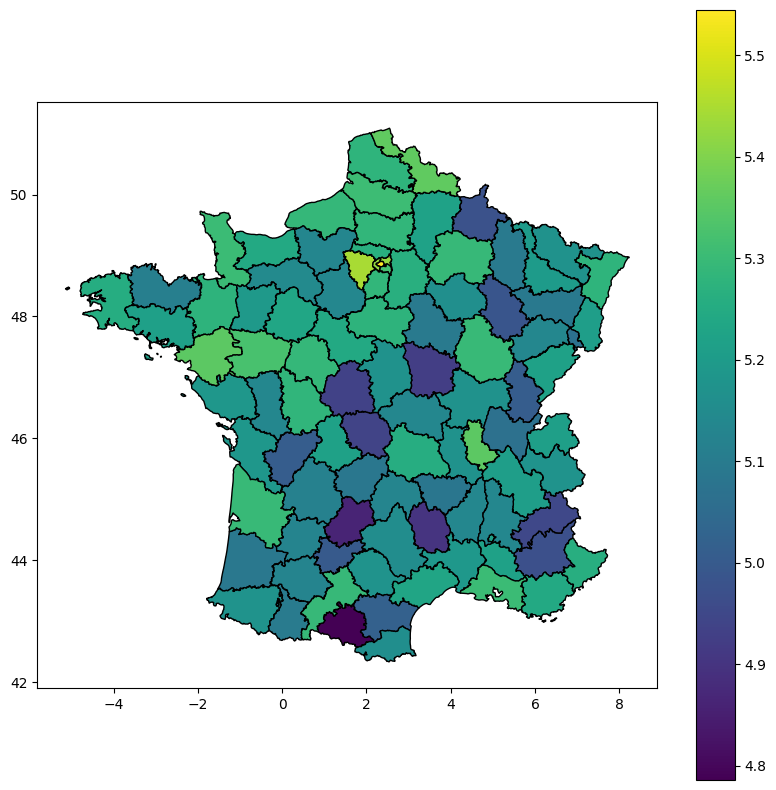

In [3]:
import geopandas as gpd

# Charger le shapefile des départements français
depts = gpd.read_file(
    "https://france-geojson.gregoiredavid.fr/repo/departements.geojson")
depts["code"] = depts["code"].astype(str).str.zfill(2)

# Filtrer pour une année donnée
annee = "2020"
df_annee = df[df["annais"] == annee]

# Moyenne pondérée de la longueur par département
heat = (
    df_annee.groupby(["dpt"])
    .apply(lambda g: (g["longueur"] * g["nombre"]).sum() / g["nombre"].sum())
    .reset_index(name="longueur_moyenne")
)

# Merge avec les géométries
heatmap = depts.merge(heat, how="left", left_on="code", right_on="dpt")

# Affichage
heatmap.plot(
    column="longueur_moyenne",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    figsize=(10, 10)
)

In [4]:
def prenom_plus_court(groupe):
    mini = groupe[groupe["longueur"] == groupe["longueur"].min()]
    return mini.sort_values("nombre", ascending=False).iloc[0][["preusuel", "nombre"]]

def prenom_plus_utilisé(groupe):
    maxi = groupe[groupe["nombre"] == groupe["nombre"].max()]
    return maxi.iloc[0][["preusuel", "nombre"]]

# --- Prénoms les plus courts ---
courts = df.groupby(["annais", "sexe"]).apply(prenom_plus_court).reset_index()
courts_pivot = courts.pivot(index="annais", columns="sexe", values=["preusuel", "nombre"])
courts_pivot.columns = ["preusuel_f_court", "preusuel_m_court", "nombre_f_court", "nombre_m_court"]

# --- Prénoms les plus utilisés ---
utilises = df.groupby(["annais", "sexe"]).apply(prenom_plus_utilisé).reset_index()
utilises_pivot = utilises.pivot(index="annais", columns="sexe", values=["preusuel", "nombre"])
utilises_pivot.columns = ["preusuel_f_freq", "preusuel_m_freq", "nombre_f_freq", "nombre_m_freq"]

# --- Fusion ---
info = pd.concat([courts_pivot, utilises_pivot], axis=1).sort_index()

fig = go.Figure()

# Garçons
fig.add_trace(go.Scatter(
    x=moyennes.index, y=moyennes[1],
    mode='lines+markers',
    name='Filles',
    hovertext=[
        f"Plus court : {pc} ({int(nc)})<br>"
        f"Plus utilisé : {pf} ({int(nf)})"
        for annee, pc, nc, pf, nf in zip(
            moyennes.index,
            info["preusuel_m_court"], info["nombre_m_court"],
            info["preusuel_m_freq"], info["nombre_m_freq"]
        )
    ],
    line=dict(color='deeppink')
))

# Filles
fig.add_trace(go.Scatter(
    x=moyennes.index, y=moyennes[2],
    mode='lines+markers',
    name='Garçons',
    hovertext=[
        f"Plus court : {pc} ({int(nc)})<br>"
        f"Plus utilisé : {pf} ({int(nf)})"
        for annee, pc, nc, pf, nf in zip(
            moyennes.index,
            info["preusuel_f_court"], info["nombre_f_court"],
            info["preusuel_f_freq"], info["nombre_f_freq"]
        )
    ],
    line=dict(color='teal')
))

fig.update_layout(
    title="Longueur moyenne des prénoms par année",
    xaxis_title="Année",
    yaxis_title="Nombre de lettres",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()


/var/folders/95/gv_9n07j7510pvhlzz5_mld80000gn/T/ipykernel_67051/1969157139.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  courts = df.groupby(["annais", "sexe"]).apply(prenom_plus_court).reset_index()
/var/folders/95/gv_9n07j7510pvhlzz5_mld80000gn/T/ipykernel_67051/1969157139.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  utilises = df.groupby(["annais", "sexe"]).apply(prenom_plus_utilisé).reset_index()
